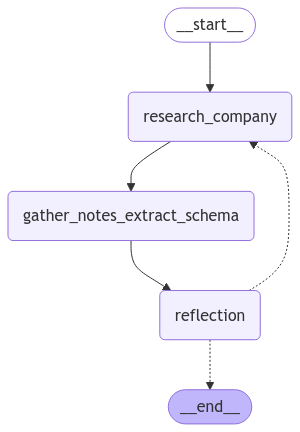

In [15]:
import asyncio
import operator
import json

from tavily import TavilyClient, AsyncTavilyClient

from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langsmith import traceable

from langgraph.constants import Send
from langgraph.graph import START, END, StateGraph

from pydantic import BaseModel, Field
from typing_extensions import Annotated, Any, List, Optional, Literal
from dataclasses import dataclass, field

import configuration

# -----------------------------------------------------------------------------
# LLMs
gpt_4o = ChatOpenAI(model="gpt-4o", temperature=0)
claude_3_5_sonnet = ChatAnthropic(model="claude-3-5-sonnet-20240620", temperature=0)

# -----------------------------------------------------------------------------
# Search
tavily_client = TavilyClient()
tavily_async_client = AsyncTavilyClient()

# -----------------------------------------------------------------------------
# Utils
@traceable
async def tavily_search_async(search_queries, tavily_topic, tavily_days):
    """
    Performs concurrent web searches using the Tavily API.

    Args:
        search_queries (List[SearchQuery]): List of search queries to process
        tavily_topic (str): Type of search to perform ('news' or 'general')
        tavily_days (int): Number of days to look back for news articles (only used when tavily_topic='news')

    Returns:
        List[dict]: List of search results from Tavily API, one per query

    Note:
        For news searches, each result will include articles from the last `tavily_days` days.
        For general searches, the time range is unrestricted.
    """

    search_tasks = []
    for query in search_queries:
        if tavily_topic == "news":
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=5,
                    include_raw_content=True,
                    topic="news",
                    days=tavily_days,
                )
            )
        else:
            search_tasks.append(
                tavily_async_client.search(
                    query, max_results=5, include_raw_content=True, topic="general"
                )
            )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)

    return search_docs


def deduplicate_and_format_sources(
    search_response, max_tokens_per_source, include_raw_content=True
):
    """
    Takes either a single search response or list of responses from Tavily API and formats them.
    Limits the raw_content to approximately max_tokens_per_source.
    include_raw_content specifies whether to include the raw_content from Tavily in the formatted string.

    Args:
        search_response: Either:
            - A dict with a 'results' key containing a list of search results
            - A list of dicts, each containing search results

    Returns:
        str: Formatted string with deduplicated sources
    """
    # Convert input to list of results
    if isinstance(search_response, dict):
        sources_list = search_response["results"]
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and "results" in response:
                sources_list.extend(response["results"])
            else:
                sources_list.extend(response)
    else:
        raise ValueError(
            "Input must be either a dict with 'results' or a list of search results"
        )

    # Deduplicate by URL
    unique_sources = {}
    for source in sources_list:
        if source["url"] not in unique_sources:
            unique_sources[source["url"]] = source

    # Format output
    formatted_text = "Sources:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += (
            f"Most relevant content from source: {source['content']}\n===\n"
        )
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get("raw_content", "")
            if raw_content is None:
                raw_content = ""
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"

    return formatted_text.strip()


def format_all_notes(completed_notes: list[str]) -> str:
    """Format a list of notes into a string"""
    formatted_str = ""
    for idx, company_notes in enumerate(completed_notes, 1):
        formatted_str += f"""
{'='*60}
Note: {idx}:
{'='*60}
Notes from research:
{company_notes}"""
    return formatted_str


# -----------------------------------------------------------------------------
# Schema
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")


class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description="List of search queries.",
    )


DEFAULT_EXTRACTION_SCHEMA = {
    "title": "CompanyInfo",
    "description": "Basic information about a company",
    "type": "object",
    "properties": {
        "company_name": {
            "type": "string",
            "description": "Official name of the company"
        },
        "founding_year": {
            "type": "integer",
            "description": "Year the company was founded"
        },
        "founder_names": {
            "type": "array",
            "items": {"type": "string"},
            "description": "Names of the founding team members"
        },
        "product_description": {
            "type": "string",
            "description": "Brief description of the company's main product or service"
        },
        "funding_summary": {
            "type": "string",
            "description": "Summary of the company's funding history"
        }
    },
    "required": ["company_name"]
}

@dataclass(kw_only=True)
class InputState:
    """Input state defines the interface between the graph and the user (external API)."""

    company: str
    "Company to research provided by the user."

    extraction_schema:  dict[str, Any] = field(
        default_factory=lambda: DEFAULT_EXTRACTION_SCHEMA
    )
    "The json schema defines the information the agent is tasked with filling out."

    user_notes: Optional[dict[str, Any]] = field(default=None)
    "Any notes from the user to start the research process."


@dataclass(kw_only=True)
class OverallState:
    """Input state defines the interface between the graph and the user (external API)."""

    company: str
    "Company to research provided by the user."

    extraction_schema:  dict[str, Any] = field(
        default_factory=lambda: DEFAULT_EXTRACTION_SCHEMA
    )
    "The json schema defines the information the agent is tasked with filling out."

    user_notes: str = field(default=None)
    "Any notes from the user to start the research process."

    completed_notes: Annotated[list, operator.add] = field(default_factory=list)
    "Notes from completed research related to the schema"

    info: dict[str, Any] = field(default=None)
    """
    A dictionary containing the extracted and processed information
    based on the user's query and the graph's execution.
    This is the primary output of the enrichment process.
    """

    is_satisfactory: bool = field(default=None)
    "True if all required fields are well populated, False otherwise"

    reflection_search_queries: list[str] = field(default=None)
    "If is_satisfactory is False, provide targeted search queries to find the missing information"

    reflection_steps_taken: int = field(default=0)
    "Number of times the reflection node has been executed"

@dataclass(kw_only=True)
class OutputState:
    """The response object for the end user.

    This class defines the structure of the output that will be provided
    to the user after the graph's execution is complete.
    """

    info: dict[str, Any]
    """
    A dictionary containing the extracted and processed information
    based on the user's query and the graph's execution.
    This is the primary output of the enrichment process.
    """


# -----------------------------------------------------------------------------
# Prompts

extraction_prompt = """Your task is to take notes gather from web research

and extract them into the following schema. 

<schema>
{info}
</schema>

Here are all the notes from research:

<Web research notes>
{notes}
<Web research notes>
 """

query_writer_instructions = """You are a search query generator tasked with creating targeted search queries to gather specific company information.

Here is the company you are researching: {company}

Generate at most {max_search_queries} search queries that will help gather the following information:

<schema>
{info}
</schema>

Your query should:
1. Focus on finding factual, up-to-date company information
2. Target official sources, news, and reliable business databases
3. Prioritize finding information that matches the schema requirements
4. Include the company name and relevant business terms
5. Be specific enough to avoid irrelevant results

Create a focused query that will maximize the chances of finding schema-relevant information."""

_INFO_PROMPT = """You are doing web research on a company, {company}. 

The following schema shows the type of information we're interested in:

<schema>
{info}
</schema>

You have just scraped website content. Your task is to take clear, organized notes about the company, focusing on topics relevant to our interests.

<Website contents>
{content}
</Website contents>

Here are any additional notes from the user:
<User notes>
{user_notes}
</User notes>

Please provide detailed research notes that:
1. Are well-organized and easy to read
2. Focus on topics mentioned in the schema
3. Include specific facts, dates, and figures when available
4. Maintain accuracy of the original content
5. Note when important information appears to be missing or unclear

Remember: Don't try to format the output to match the schema - just take clear notes that capture all relevant information."""

REFLECTION_PROMPT = """You are a research analyst tasked with reviewing the quality and completeness of extracted company information.

Compare the extracted information with the required schema:

<Schema>
{schema}
</Schema>

Here is the extracted information:
<Extracted Info>
{info}
</Extracted Info>

Analyze if all required fields are present and sufficiently populated. Consider:
1. Are any required fields missing?
2. Are any fields incomplete or containing uncertain information?
3. Are there fields with placeholder values or "unknown" markers?

Return a structured response that has the following fields:
- "is_satisfactory": boolean,  # True if all required fields are well populated, False otherwise
- "missing_fields": [string],  # List of field names that are missing or incomplete
- "reflection_search_queries": [string],  # If is_satisfactory is False, provide {max_search_queries} targeted search queries to find the missing information
- "reasoning": string  # Brief explanation of your assessment

"""

class ReflectionOutput(BaseModel):
    is_satisfactory: bool = Field(
        description="True if all required fields are well populated, False otherwise"
    )
    missing_fields: List[str] = Field(
        description="List of field names that are missing or incomplete"
    )
    reflection_search_queries: List[str] = Field(
        description="If is_satisfactory is False, provide 1-3 targeted search queries to find the missing information"
    )
    reasoning: str = Field(
        description="Brief explanation of the assessment"
    )

# -----------------------------------------------------------------------------
# Nodes

async def research_company(state: OverallState, config: RunnableConfig) -> str:
    """Execute a multi-step web search and information extraction process.

    This function performs the following steps:
    1. Generates multiple search queries based on the input query
    2. Executes concurrent web searches using the Tavily API
    3. Deduplicates and formats the search results
    4. Extracts structured information based on the provided schema

    Args:
        query: The initial search query string
        state: Injected application state containing the extraction schema
        config: Runtime configuration for the search process

    Returns:
        str: Structured notes from the search results that are
         relevant to the extraction schema in state.extraction_schema

    Note:
        The function uses concurrent execution for multiple search queries to improve
        performance and combines results from various sources for comprehensive coverage.
    """

    # Get configuration
    configurable = configuration.Configuration.from_runnable_config(config)
    max_search_queries = configurable.max_search_queries
    max_search_results = configurable.max_search_results

    # Initialize search client
    tavily_async_client = AsyncTavilyClient()

    # Generate search queries
    structured_llm = claude_3_5_sonnet.with_structured_output(Queries)

    # Check reflection output - access attribute directly
    reflection_output = getattr(state, "is_satisfactory", None)
    reflection_queries = getattr(state, "reflection_search_queries", None)
    
    # If we have performed reflection and have new search queries 
    if reflection_output is not None and reflection_queries:
        # Get generated search queries
        query_list = reflection_queries
    else:
        # Format system instructions
        query_instructions = query_writer_instructions.format(
            company=state.company,
            info=json.dumps(state.extraction_schema, indent=2),
            max_search_queries=max_search_queries,
        )

        # Generate queries
        results = structured_llm.invoke(
            [SystemMessage(content=query_instructions)]
            + [
                HumanMessage(
                    content=f"Please generate a list of search queries related to the schema that you want to populate."
                )
            ]
        )

        # Queries
        query_list = [query.search_query for query in results.queries]

    # Search tasks
    search_tasks = []
    for query in query_list:
        search_tasks.append(
            tavily_async_client.search(
                query,
                max_results=max_search_results,
                include_raw_content=True,
                topic="general",
            )
        )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)

    # Deduplicate and format sources
    source_str = deduplicate_and_format_sources(
        search_docs, max_tokens_per_source=1000, include_raw_content=True
    )

    # Generate structured notes relevant to the extraction schema
    p = _INFO_PROMPT.format(
        info=json.dumps(state.extraction_schema, indent=2),
        content=source_str,
        company=state.company,
        user_notes=state.user_notes,
    )
    result = await claude_3_5_sonnet.ainvoke(p)
    return {"completed_notes": [str(result.content)]}

def gather_notes_extract_schema(state: OverallState) -> dict[str, Any]:
    """Gather notes from the web search and extract the schema fields."""

    # Format all notes
    notes = format_all_notes(state.completed_notes)

    # Extract schema fields
    system_prompt = extraction_prompt.format(
        info=json.dumps(state.extraction_schema, indent=2), notes=notes
    )
    structured_llm = claude_3_5_sonnet.with_structured_output(state.extraction_schema)
    result = structured_llm.invoke(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=f"Produce a structured output from these notes."),
        ]
    )
    return {"info": result}

def reflection(state: OverallState, config: RunnableConfig) -> dict[str, Any]:
    """Reflect on the extracted information and generate search queries to find missing information."""

    # Get configuration
    configurable = configuration.Configuration.from_runnable_config(config)

    # Generate search queries
    structured_llm = claude_3_5_sonnet.with_structured_output(ReflectionOutput)

    # Format reflection prompt
    system_prompt = REFLECTION_PROMPT.format(schema=json.dumps(state.extraction_schema, indent=2), 
                                                 info=state.info, 
                                                 max_search_queries=configurable.max_search_queries)

    # Invoke
    result = structured_llm.invoke(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=f"Produce a structured reflection output."),
        ]
    )

    if result.is_satisfactory:
        return {"is_satisfactory":result.is_satisfactory}
    else:
        return {"is_satisfactory":result.is_satisfactory, 
                "reflection_search_queries": result.reflection_search_queries,
                "reflection_steps_taken": state.reflection_steps_taken + 1}

def route_from_reflection(state: OverallState, config: RunnableConfig) -> Literal["__end__", "research_company"]:
    """Route the graph based on the reflection output."""

    # Get configuration
    configurable = configuration.Configuration.from_runnable_config(config)
    
    # If we have satisfactory results, end the process
    if state.is_satisfactory:
        return END
        
    # If results aren't satisfactory but we haven't hit max steps, continue research
    if state.reflection_steps_taken <= configurable.max_reflection_steps:
        return "research_company"
        
    # If we've exceeded max steps, end even if not satisfactory
    return END

# Add nodes and edges
builder = StateGraph(
    OverallState,
    input=InputState,
    output=OutputState,
    config_schema=configuration.Configuration,
)
builder.add_node("gather_notes_extract_schema", gather_notes_extract_schema)
builder.add_node("research_company", research_company)
builder.add_node("reflection", reflection)

builder.add_edge(START, "research_company")
builder.add_edge("research_company", "gather_notes_extract_schema")
builder.add_edge("gather_notes_extract_schema", "reflection")
builder.add_conditional_edges("reflection", route_from_reflection)

# Compile
graph = builder.compile()

# View
from IPython.display import Image, display
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [2]:
## Test default schema 

# Create proper InputState instance
input_state = InputState(
    company="LangChain",
)

# Invoke with the proper input state
result = await graph.ainvoke(input_state)
result

{'info': {'company_name': 'LangChain',
  'founding_year': 2022,
  'founder_names': ['Harrison Chase', 'Ankush Gola'],
  'product_description': 'LangChain is an open-source framework for developing applications using large language models (LLMs). It provides tools and APIs to simplify building LLM-driven applications like chatbots and virtual agents. The framework offers flexible abstractions and an AI-first toolkit for building context-aware reasoning applications, serving as a generic interface for nearly any LLM. It allows integration with external data sources and software workflows, and its modular approach enables developers to compare different prompts and foundation models with minimal code rewriting.',
  'funding_summary': 'LangChain has raised a total of $35 million. This includes a $25 million Series A round led by Sequoia Capital on February 15, 2024, and a $10 million Seed round led by Benchmark on April 4, 2023. The company\'s valuation was reported to be "at least $200 mi

In [3]:
## Test remote graph connected w/ Studio 

from langgraph.pregel.remote import RemoteGraph

url = "http://localhost:60827"
graph_id = "company_maistro"

graph = RemoteGraph(graph_id, url=url)

# Some input to the graph
input = {"company":"langchain"}

# Can also be a subgraph in an existing graph
response = await graph.ainvoke(input)
response

{'company': 'langchain',
 'completed_notes': ["Research Notes: LangChain\n\nCompany Name:\n- LangChain\n\nFounding Year:\n- 2022 (mentioned in multiple sources)\n\nFounders:\n- Harrison Chase (Co-Founder & CEO)\n- Ankush Gola (Co-Founder)\n\nProduct Description:\n- Open source framework for developing applications using large language models (LLMs)\n- Provides tools and APIs to simplify building LLM-driven applications like chatbots and virtual agents\n- Offers flexible abstractions and an AI-first toolkit\n- Helps connect LLMs to private data sources and APIs to create context-aware, reasoning applications\n- Includes integrations with various cloud storage, APIs, databases, and LLM providers\n\nFunding Summary:\n- Total raised: $35 million (as of July 2023)\n- Latest round: $25 million Series A (April 2023)\n- Led by Sequoia Capital\n- Previous round: $10 million seed round led by Benchmark (announced April 4, 2023)\n- Valuation: At least $200 million (as of April 2023)\n\nAdditional

In [14]:
## Test SDK connected w/ Studio 

from langgraph_sdk import get_client
client = get_client(url="http://localhost:60827")
new_thread = await client.threads.create()
async for chunk in client.runs.stream(new_thread["thread_id"], 
                                      assistant_id="25f608e5-2c8c-565f-a5f2-39604c6d4ff4",
                                      input={"company":"langchain"},
                                      stream_mode="values"):

    if chunk.event == 'values':
        print(chunk.data)

{'company': 'langchain', 'completed_notes': []}
{'company': 'langchain', 'completed_notes': ["Research Notes: LangChain\n\nCompany Name:\n- LangChain\n\nFounding Year:\n- 2022 (mentioned in multiple sources)\n\nFounders:\n- Harrison Chase (Co-Founder & CEO)\n- Ankush Gola (Co-Founder)\n\nProduct Description:\n- Open source framework for developing applications using large language models (LLMs)\n- Provides tools and APIs to simplify building LLM-driven applications like chatbots and virtual agents\n- Offers flexible abstractions and an AI-first toolkit\n- Helps connect LLMs to private data sources and APIs to create context-aware, reasoning applications\n- Includes integrations with various cloud storage, APIs, databases, and LLM providers\n\nFunding Summary:\n- Total raised: $35 million (as of July 2023)\n- Latest round: $25 million Series A (April 2023)\n- Led by Sequoia Capital\n- Previous round: $10 million seed round led by Benchmark (announced April 4, 2023)\n- Valuation: At leas

In [26]:
## Test hard schema 

HARD_EXTRACTION_SCHEMA = {
    "title": "CompanyInfo",
    "description": "Comprehensive information about a company with confidence tracking",
    "type": "object",
    "properties": {
        "company_name": {
            "type": "string",
            "description": "Official name of the company"
        },
        "verified_company": {
            "type": "boolean",
            "description": "Confirmation this is the intended company, not a similarly named one"
        },
        "similar_companies": {
            "type": "array",
            "items": {"type": "string"},
            "description": "List of similarly named companies that could be confused with the target"
        },
        "distinguishing_features": {
            "type": "string",
            "description": "Key features that distinguish this company from similarly named ones"
        },
        "key_executives": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "name": {"type": "string"},
                    "title": {"type": "string"},
                    "verification_date": {"type": "string"},
                    "confidence_level": {
                        "type": "string",
                        "enum": ["high", "medium", "low", "uncertain"]
                    },
                    "source": {"type": "string"}
                }
            }
        },
        "org_chart_summary": {
            "type": "string",
            "description": "Brief description of organizational structure"
        },
        "leadership_caveats": {
            "type": "string",
            "description": "Any uncertainties or caveats about leadership information"
        },
        "main_products": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "name": {"type": "string"},
                    "description": {"type": "string"},
                    "launch_date": {"type": "string"},
                    "current_status": {"type": "string"}
                }
            }
        },
        "services": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "name": {"type": "string"},
                    "description": {"type": "string"},
                    "target_market": {"type": "string"}
                }
            }
        },
        "recent_developments": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "date": {"type": "string"},
                    "title": {"type": "string"},
                    "summary": {"type": "string"},
                    "source_url": {"type": "string"},
                    "significance": {"type": "string"}
                }
            },
            "description": "Major news and developments from the last 6 months"
        },
        "historical_challenges": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "issue_type": {"type": "string"},
                    "description": {"type": "string"},
                    "date_period": {"type": "string"},
                    "resolution": {"type": "string"},
                    "current_status": {"type": "string"}
                }
            },
            "description": "Past challenges, issues, or controversies"
        },
        "sources": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "url": {"type": "string"},
                    "title": {"type": "string"},
                    "date_accessed": {"type": "string"},
                    "information_type": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "Types of information sourced from this link (e.g., leadership, products, news)"
                    }
                }
            }
        },
        "company_summary": {
            "type": "string",
            "description": "Concise, dense summary of the most important company information (max 250 words)"
        }
    },
    "required": [
        "company_name",
        "verified_company",
        "company_summary",
        "key_executives",
        "main_products",
        "sources"
    ]
}

# Create proper InputState instance
input_state = InputState(
    company="LangChain",
    extraction_schema=HARD_EXTRACTION_SCHEMA,
)

# Invoke with the proper input state
result = await graph.ainvoke(input_state)

{'info': {'company_name': 'LangChain',
  'verified_company': True,
  'company_summary': "LangChain is a San Francisco-based technology company founded in 2022 that develops an AI-powered large language model (LLM) framework. The company has raised approximately $30-35 million in funding and was valued at over $200 million as of April 2023. LangChain's main products include the LangChain Framework, LangGraph Cloud, LangSmith, and LangServe, all designed to simplify the creation and deployment of LLM-based applications. With a strong focus on community engagement and rapid product evolution, LangChain has gained significant traction among developers and continues to expand its offerings in the AI industry.",
  'key_executives': [{'name': 'Harrison Chase',
    'title': 'Co-Founder & CEO',
    'verification_date': '2023-07-01',
    'confidence_level': 'high',
    'source': 'https://craft.co/langchain'},
   {'name': 'Ankush Gola',
    'title': 'Co-Founder',
    'verification_date': '2023-07